In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from keras import layers

# AE Architecture

In [11]:
input_img = keras.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(2, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(2, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((1, 1), padding="same")(x)

# Decoder
decoder_input = layers.Conv2DTranspose(4, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(decoder_input)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.save_weights('initial_model.h5')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 2)         290       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 2)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 2)           38  

In [8]:
from stacked_mnist import StackedMNISTData, DataMode
from tensorflow import keras
import numpy as np

generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = generator.get_full_data_set(training=True)
x_test, y_test = generator.get_full_data_set(training=False)

# "Translate": Only look at "red" channel; only use the last digit. Use one-hot for labels during training
x_train = x_train[:, :, :, [0]]
y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
x_test = x_test[:, :, :, [0]]
y_test = keras.utils.to_categorical((y_test % 10).astype(np.int), 10)

In [9]:
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5


ValueError: in user code:

    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/losses.py", line 1807, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/backend.py", line 5158, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 32, 32, 1) vs (None, 28, 28, 1)).


# AE Reconstruction Results

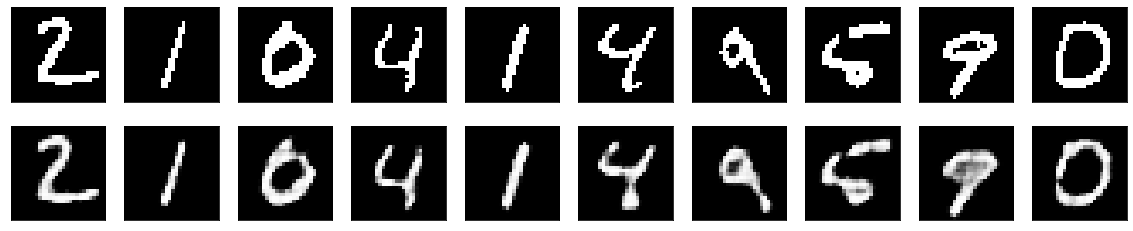

In [171]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [172]:
from verification_net import VerificationNet

net = VerificationNet(force_learn=False, file_name="../models/verification_model")
img, labels = generator.get_random_batch(training=False, batch_size=25000)
decoded_imgs = autoencoder.predict(img)
_, acc_ae = net.check_predictability(data=decoded_imgs, correct_labels=labels)
_, acc_orig = net.check_predictability(data=img, correct_labels=labels)
print(f"Accuracy AE: {100 * acc_ae:.2f}%")
print(f"Accuracy Original: {100 * acc_orig:.2f}%")


Accuracy AE: 82.96%
Accuracy Original: 95.80%


# AE as a generative model

In [173]:
import numpy as np

z = np.random.randn(100, 14, 14, 8)

decoder = keras.Model(decoder_input, decoded)
decoded_z = decoder.predict(z)

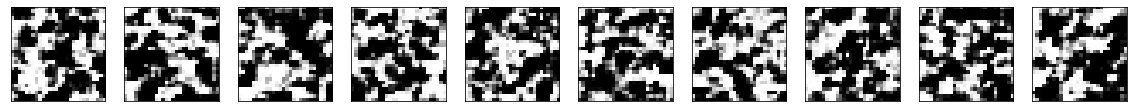

In [176]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(decoded_z[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [86]:
cov = net.check_class_coverage(data=decoded_z, tolerance=0.98)
print(f"Coverage: {100*cov:.2f}%")

Coverage: 20.00%


# AE as an anomaly detector

In [ ]:
autoencoder.load_weights('initial_model.h5')

generator = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING, default_batch_size=2048)

x_train, y_train = generator.get_full_data_set(training=True)
x_test, y_test = generator.get_full_data_set(training=False)

# "Translate": Only look at "red" channel; only use the last digit. Use one-hot for labels during training
x_train = x_train[:, :, :, [0]]
y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
x_test = x_test[:, :, :, [0]]
y_test = keras.utils.to_categorical((y_test % 10).astype(np.int), 10)

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
reconstructed = autoencoder.predict(x_test)


In [ ]:
from tensorflow.keras.losses import binary_crossentropy
losses = binary_crossentropy(x_test, reconstructed).numpy()
largest_loss = np.argpartition(losses, -5)[-5:]

plt.figure(figsize=(5, 4))
for i in range(1, 5):
    # Display original
    ax = plt.subplot(i, 5)
    plt.imshow(decoded_z[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()